In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
from hospital import *

In [3]:
hh = hosp('hh')

----------------------------------------
Created hosp class instance:  hh
----------------------------------------
--------------------
Patient fileload: 
--------------------
Found:  hhEDpat.pkl
Missing:  hhIPpat.pkl
--------------------
Daily fileload: 
--------------------
Missing:  hhEDday.pkl
Missing:  hhIPday.pkl


In [4]:
df = hh.pat.get_ED()

In [5]:
ts = df.groupby('arrive_date').count()['hosp_patid']

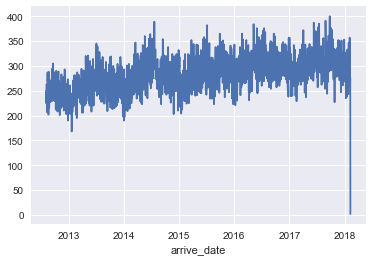

In [6]:
ts.plot()

In [7]:
pd.to_datetime(ts.index)

DatetimeIndex(['2012-08-01', '2012-08-02', '2012-08-03', '2012-08-04',
               '2012-08-05', '2012-08-06', '2012-08-07', '2012-08-08',
               '2012-08-09', '2012-08-10',
               ...
               '2018-01-31', '2018-02-01', '2018-02-02', '2018-02-03',
               '2018-02-04', '2018-02-05', '2018-02-06', '2018-02-07',
               '2018-02-08', '2018-02-09'],
              dtype='datetime64[ns]', name='arrive_date', length=2019, freq=None)

In [8]:
ts = ts.reset_index(level=0)

In [9]:
ts.dtypes

arrive_date    object
hosp_patid      int64
dtype: object

In [10]:
ts = ts[:-1]

In [11]:
ts.arrive_date = pd.to_datetime(ts.arrive_date)

In [12]:
ts['year'] = ts.arrive_date.apply(lambda x : x.year)

In [13]:
ts['month'] = ts.arrive_date.apply(lambda x : x.month)

In [14]:
month_descr = ts.groupby(['year','month']).describe().reset_index()

In [15]:
month_descr.head()

year month hosp_patid                                                       \
                   count        mean        std    min     25%    50%     75%   
0  2012     8       31.0  242.580645  22.855742  202.0  227.00  240.0  253.00   
1  2012     9       30.0  253.833333  20.299623  229.0  240.00  247.5  268.50   
2  2012    10       31.0  243.161290  26.604632  201.0  218.50  238.0  264.50   
3  2012    11       30.0  242.300000  20.027825  210.0  226.25  241.0  254.25   
4  2012    12       31.0  234.483871  25.409803  190.0  219.50  225.0  251.00   

          
     max  
0  288.0  
1  305.0  
2  290.0  
3  283.0  
4  293.0

In [16]:
month_descr['hosp_patid'].columns = list(month_descr.columns.levels[1])[:-1]

In [17]:
month_descr.head()

year month hosp_patid                                                       \
                   count        mean        std    min     25%    50%     75%   
0  2012     8       31.0  242.580645  22.855742  202.0  227.00  240.0  253.00   
1  2012     9       30.0  253.833333  20.299623  229.0  240.00  247.5  268.50   
2  2012    10       31.0  243.161290  26.604632  201.0  218.50  238.0  264.50   
3  2012    11       30.0  242.300000  20.027825  210.0  226.25  241.0  254.25   
4  2012    12       31.0  234.483871  25.409803  190.0  219.50  225.0  251.00   

          
     max  
0  288.0  
1  305.0  
2  290.0  
3  283.0  
4  293.0

In [18]:
col_names = ['year','month'] + list(month_descr.columns.levels[1])[:-1]

In [19]:
month_descr = pd.DataFrame(month_descr.as_matrix(),columns=col_names)

In [20]:
ts = ts.merge(month_descr,on = ['year','month'])

In [21]:
ts.rename(columns={'hosp_patid':'patient_count'},inplace=True)

In [22]:
ts.set_index('arrive_date',inplace=True)

In [23]:
ts.head()

,patient_count,year,month,count,mean,std,min,25%,50%,75%,max
arrive_date,,,,,,,,,,,
2012-08-01,249,2012,8,31.0,242.580645,22.855742,202.0,227.0,240.0,253.0,288.0
2012-08-02,225,2012,8,31.0,242.580645,22.855742,202.0,227.0,240.0,253.0,288.0
2012-08-03,241,2012,8,31.0,242.580645,22.855742,202.0,227.0,240.0,253.0,288.0
2012-08-04,240,2012,8,31.0,242.580645,22.855742,202.0,227.0,240.0,253.0,288.0
2012-08-05,263,2012,8,31.0,242.580645,22.855742,202.0,227.0,240.0,253.0,288.0


#### calc sdev flag

In [24]:
ts.loc[ts[ts.patient_count >= ts['50%'] + 1.2*ts['std']].index,'flag_sd'] = 1

In [25]:
ts.flag_sd.value_counts()

1.0    290
Name: flag_sd, dtype: int64

In [26]:
print('Percentage of flagged: ' + str(100*ts.flag_sd.value_counts().values[0]/ts.shape[0]) )

Percentage of flagged: 14.3706640238


#### calc rolling worst prev 5 days in month?

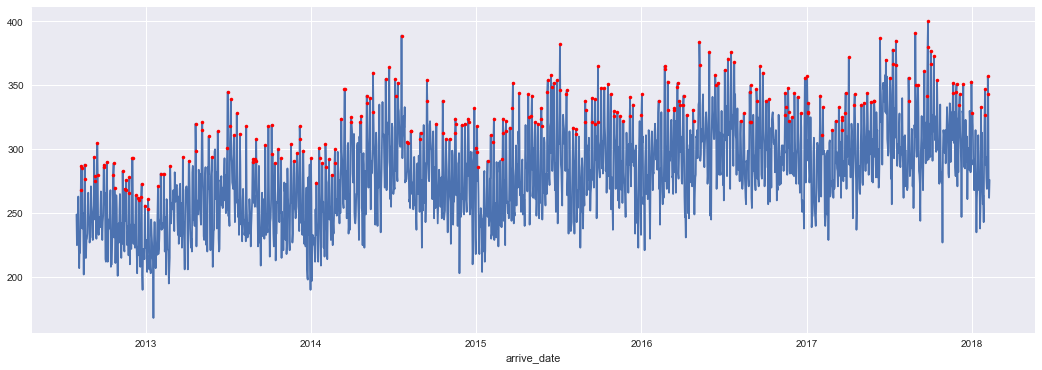

In [27]:
ax = plt.subplot()
ts['patient_count'].plot(ax=ax,figsize=(18,6))

ts[ts.flag_sd == 1]['patient_count'].plot(ax=ax,style='.r')

C:\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


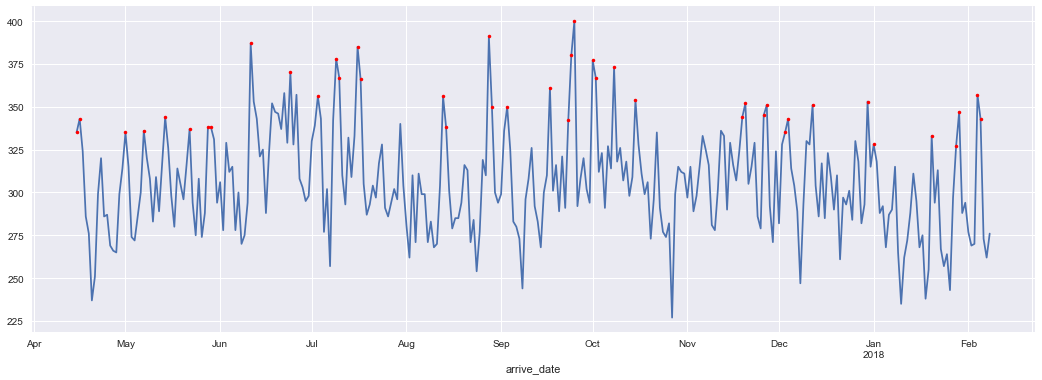

In [28]:
ax = plt.subplot()
ts[-300:]['patient_count'].plot(ax=ax,figsize=(18,6))

ts[-300:][ts.flag_sd == 1]['patient_count'].plot(ax=ax,style='.r')

# Create features

In [28]:
import featuretools as ft
#import utils
#from utils import load_nyc_taxi_data, compute_features, preview, feature_importances
#from sklearn.ensemble import GradientBoostingRegressor
from featuretools.primitives import (Weekend, Minute, Hour, Day, Week, Month,
                                     Weekday, Weekend, Count, Sum, Mean, Median, Std, Min, Max)

In [29]:
days_df = ts.reset_index()

In [31]:
days_df.sample()

,arrive_date,patient_count,year,month,count,mean,std,min,25%,50%,75%,max,flag_sd
972,2015-03-31,256,2015,3,31.0,276.806452,31.620056,225.0,253.5,271.0,294.0,352.0,NaN


In [40]:
pat

hospital.pat

In [41]:
atten_df = hh.pat.get_ED()

In [42]:
atten_df.head(1)

,hosp_patid,age,gender,site,arrive_datetime,arrive_mode,first_triage_datetime,first_dr_datetime,first_adm_request_time,adm_referral_loc,...,depart_weekday_name,depart_year,depart_date,first_adm_request_datetime,arr_triage_wait,arr_dr_wait,arr_adm_req_wait,adm_req_dep_wait,dr_adm_req_wait,dr_dep_wait
0,489709,43,Female,BNHH,2012-08-01 00:04:00,2.0,2012-08-01 00:18:00,2012-08-01 02:24:00,NaN,NaN,...,Wednesday,2012,2012-08-01,NaT,14.0,140.0,NaN,NaN,NaN,80.0


In [43]:
atten_df.arrive_date.head()

0    2012-08-01
1    2012-08-01
2    2012-08-01
3    2012-08-01
4    2012-08-01
Name: arrive_date, dtype: object

In [44]:
entities = {
    "days": (days_df, "arrive_date"),
    "attendances": (atten_df, "hosp_patid",'arrive_date'),
}

relationships = [("days", "arrive_date", "attendances", "arrive_date")]

In [45]:
trans_primitives = [Weekend]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="days",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={},
                  features_only=True)

AssertionError: Index is not unique on dataframe (Entity attendances)

In [ ]:
features